In [4]:
from __future__ import print_function

import numpy as np
import pandas as pd
from collections import OrderedDict #sorting participant df dict before pd.concat()
import matplotlib.pylab as plt
%matplotlib inline
pd.options.display.mpl_style = 'default'

import cPickle as pickle

non_english_fluent  = ['023', '031', '045', '050', '070', '106',]
left_handed = ['042', '088',]
pro_inst_skill = ['026', '037']

excluded_all_tasks = non_english_fluent + left_handed + pro_inst_skill

In [5]:
def col_matches(df, regex):
    'returns a list of columns in a df that match a regex string.'
    import re
    cols = list(enumerate(df.columns))
    matches = [c for (i, c) in cols 
               if re.findall(regex, c)]
    return matches


def compare_transformations(df, columns, functions, **kwargs):
    
    print('raw')
    df[columns].hist(**kwargs)
    plt.show()
    
    for name, func in functions.items():
       
        print(name)
        
        df[columns].apply(func).hist(**kwargs)
        plt.show()
        
        
def quickcompare(r, df, size=(15,7)): 
    inverse = lambda x: 1.0/x
    return compare_transformations(df, col_matches(df, r),
                                   {'inverse': inverse,
                                    'log1p': np.log1p,
                                    'sqrt':  np.sqrt,  
                                    'log': np.log,
                                    },
                                    figsize=size)

In [10]:
# using this for inline documentation so that it's clear
# that the printing statement isn't part of the necessary
# transformation code.
def html_print(df):
    try:
        out = df.to_html()
    except AttributeError:
        out = pd.DataFrame(df).to_html()
    return HTML(out)


def htmljoin(df_list, delimiter=''):    
    return HTML(delimiter.join([x.to_html() for x in df_list]))


def col_matches(df, regex):     
    import re    
    cols = list(enumerate(df.columns))        
    matches = [c for (i, c) in cols 
               if re.findall(regex, c)]        
    return matches


def concat_matches(df, *args):    
    assert all([len(r) for r in args])
    import re        
    col_match_lists = [col_matches(df, regex) for regex in args]    
    col_set = [df[matches] for matches in col_match_lists]    
    
    if len(col_set) == 0:
        return None    
    elif len(col_set) == 1:
        return col_set[0]    
    else:
        return pd.concat(col_set, axis=1)

    
def show_frames(frame_list, delimiter=''):
    
    from IPython.display import HTML
    
    if len(frame_list) == len(delimiter):        
        html_out = ""
        item_template = '<p><strong>{}</strong></p>{}<br>'
        
        for i, tup in enumerate(zip(frame_list, delimiter)):
            frame = tup[0]
            tag = tup[1]
            html_out += item_template.format(tag, frame.to_html())            
        return HTML(html_out)
        
    else:        
        html_out = [df.to_html() for df in frame_list]        
        return HTML(delimiter.join(html_out))

In [11]:
pfilenames = "c:/db_pickles/pickle - dfo-{measure} - {updated}.pickle"

updated_scales = '2014-10-29a'
updated_isip = '2014-10-12b'
updated_sms = '2014-10-20a'

sms_df = pd.read_pickle(pfilenames.format(measure = 'sms', updated = updated_sms))

scales_df = pd.read_pickle(pfilenames.format(measure = 'scales',
                                             updated = updated_scales))

isip_measures = ['isip5_lag2',
                 'isip5_avgprev4',
                 'isip8_lag2',
                 'isip8_avgprev4',
                 ]

isip_frames = {m: pd.read_pickle(pfilenames.format(measure = m,
                                                   updated = updated_isip))
               for m in isip_measures}

sms_frames = {'sms': sms_df}
scales_frames = {'scales': scales_df}

In [12]:
from itertools import chain

task_output = OrderedDict(chain(scales_frames.items(),
                                sms_frames.items(),
                                isip_frames.items(),
                                ))

In [17]:
dfo = pd.concat(task_output.values(), 
                axis=1, #defaults
                join='outer', 
                keys=task_output.keys(),
                names=['set'], 
                )

to_drop = set(dfo.index).intersection(excluded_all_tasks)

if to_drop:
    print("Dropping: {}".format(list(to_drop)))
    dfo = dfo.drop(to_drop)
    
assert len(set(dfo.index).intersection(excluded_all_tasks))==0

Dropping: ['026', '037']


In [18]:
full_updated = '2014-10-29a'

pfilenames = "c:/db_pickles/pickle - dfo-{measure} - {updated}.pickle"
output_file = pfilenames.format(measure='full', updated=full_updated)
pickle.dump(dfo, open(output_file, "wb"))



In [22]:
# To use this outside of pandas (R) we'll want to make a flat table
# where the outer index is converted to a prefix for the variable name.

top_level_label = {'scales':         'SCAL',
                   'sms':            'SMSR',
                   'isip8_lag2': 'I8L2',
                   'isip5_lag2': 'I5L2',
                   'isip8_avgprev4': 'I8P4',
                   'isip5_avgprev4': 'I5P4',
                    }

dfo_flat_subset = dfo.copy().xs(top_level_label.keys(), axis=1)

dfo_flat_subset.columns = ['_'.join([top_level_label[outer], inner]) 
                           for (outer, inner) in dfo_flat_subset.columns]

#shorten variable name for export
dfo_flat_subset.columns = [c.replace('avgprev4sq_', "") for c in dfo_flat_subset.columns]

In [23]:
full_updated = '2014-10-29a'
pfilenames = "c:/db_pickles/pickle - dfo-{measure} - {updated}.{ext}"
output_file_csv =    pfilenames.format(measure='flat', updated=full_updated, ext="csv")
output_file_pickle = pfilenames.format(measure='flat', updated=full_updated, ext="pickle")

pickle.dump(dfo_flat_subset, open(output_file_pickle, "wb"))

# Re-code NaNs for external analyses
dfo_coded_nan = dfo_flat_subset.replace(np.nan, 77777)
dfo_coded_nan.to_csv(output_file_csv)


In [24]:
dfo_flat_subset.T[::15]

,015,016,017,018,019,020,021,022,024,025,...,112,113,114,115,116,117,118,119,120,121
SCAL_session_day,20140228,20140303,20140303,20140303,20140303,20140303,20140304,20140304,20140304,20140304,...,20140508,20140508,20140508,20140508,20140509,20140509,20140509,20140509,20140509,20140509
SCAL_calc_bfi_openness,2.8,3.7,3.7,3.6,3.3,2.5,2.7,4.7,4.2,3.2,...,4.3,3.6,3.6,4.3,4.4,3,3.9,4.3,4.9,4.2
SCAL_notes_bfi,,,,,,,,,,,...,,,,,,,,,,
SCAL_wasivocab_itemscore02_shovel,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SCAL_wasivocab_itemscore17_decade,2,2,2,2,2,2,2,2,1,2,...,1,2,2,2,2,1,2,2,2,2
SCAL_wasimatrix_itemscore01,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SCAL_wasimatrix_itemscore16,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
SCAL_qbasic_isfemale,1,0,0,0,0,0,1,1,1,0,...,1,0,1,1,0,1,0,1,0,1
SCAL_qbasic_relationshipyears,2,0,0,0,0,0,1,0,0,0,...,1,2,0,3,0,1,0,1,0,0
SCAL_qbasic_exerciseyn,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


# Below are data explorations after the exporting work has finished...

raw


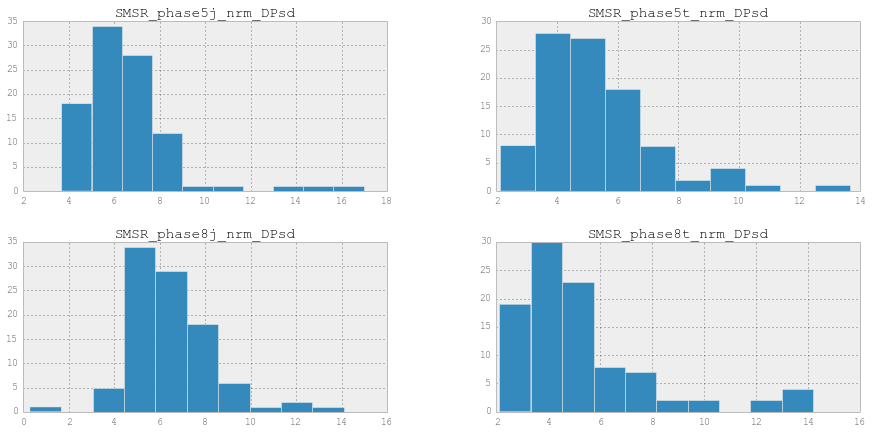

inverse


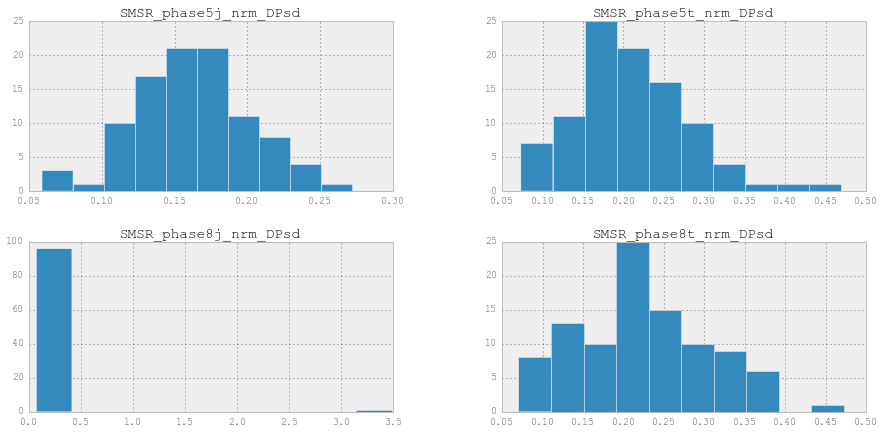

log1p


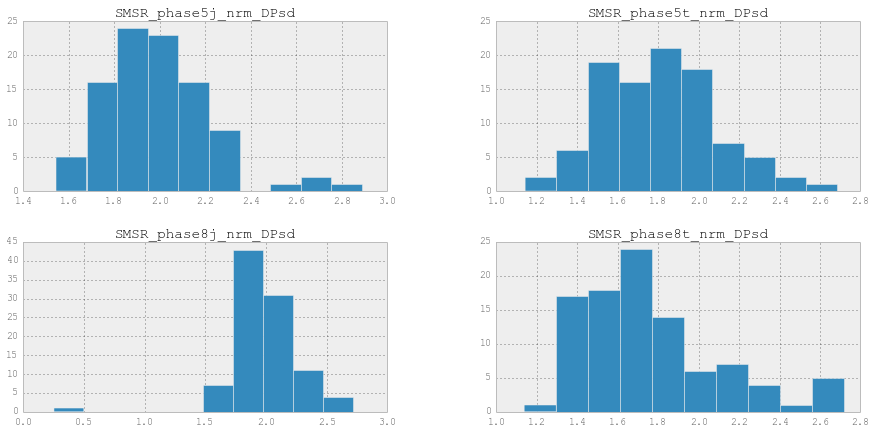

log


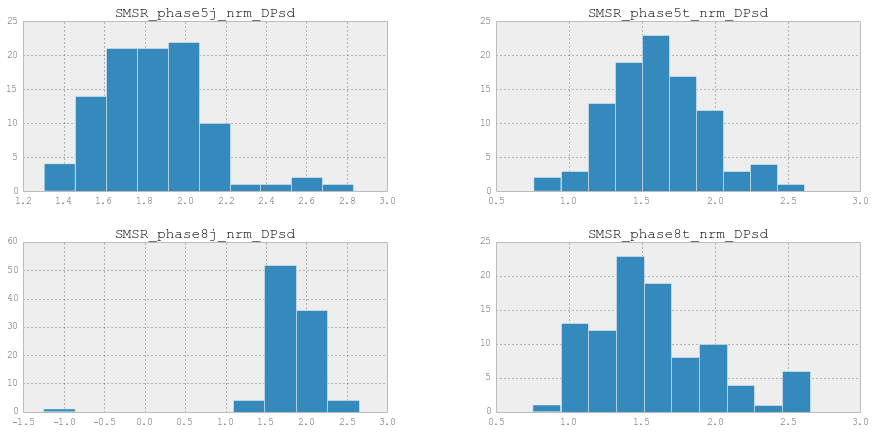

sqrt


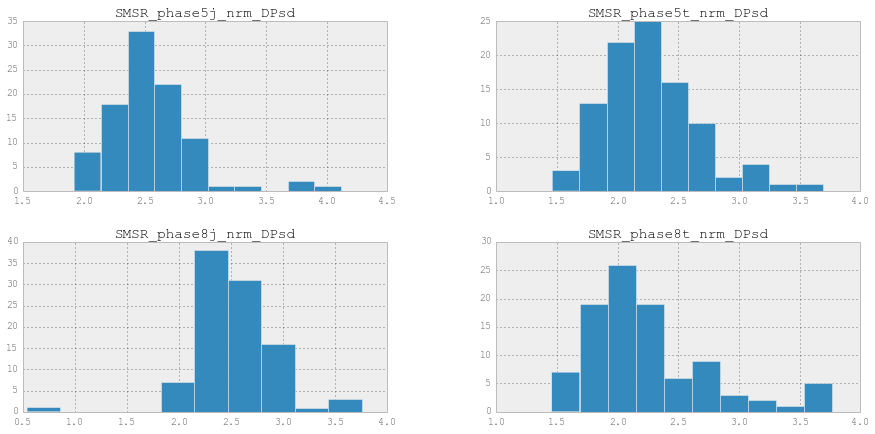

raw


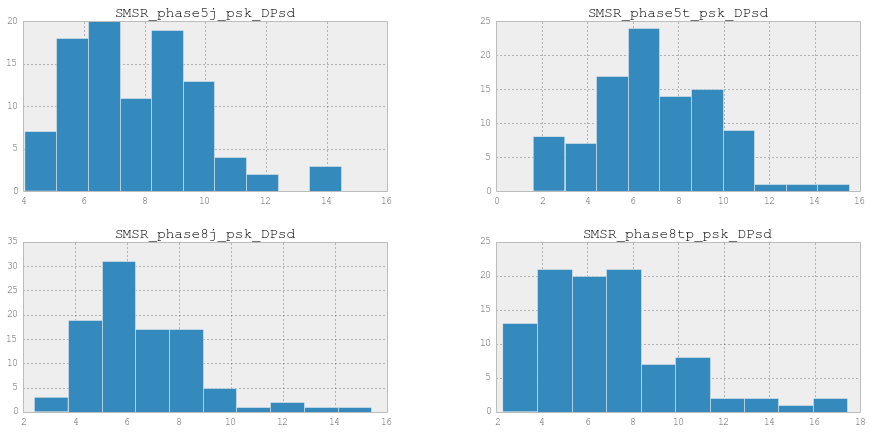

inverse


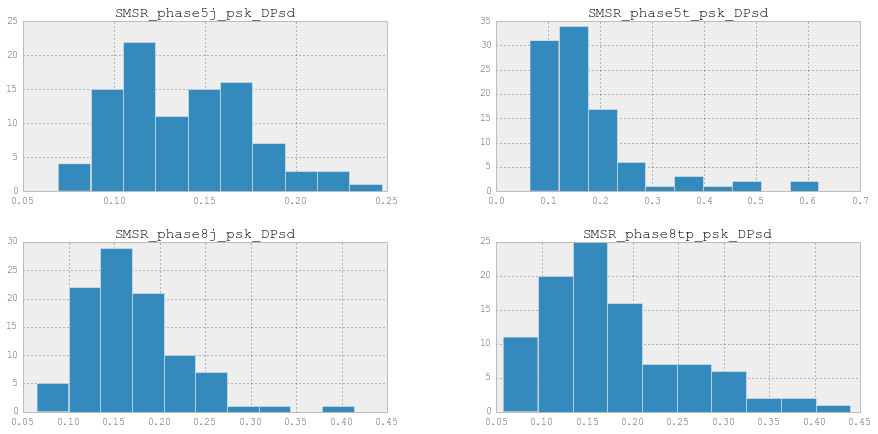

log1p


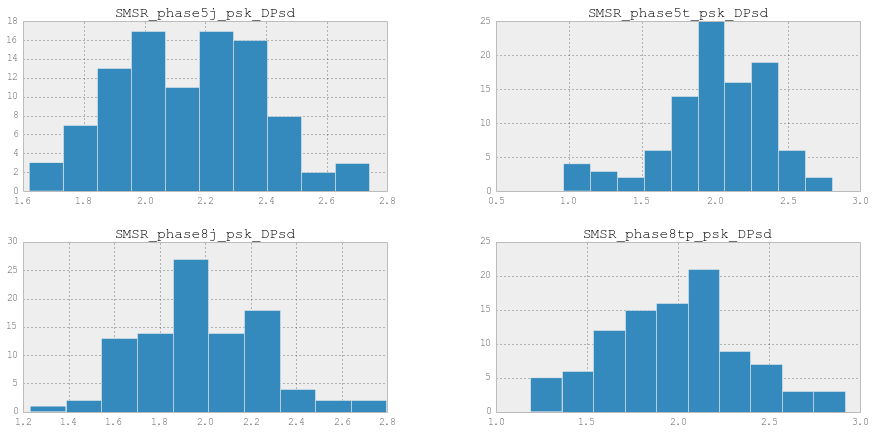

log


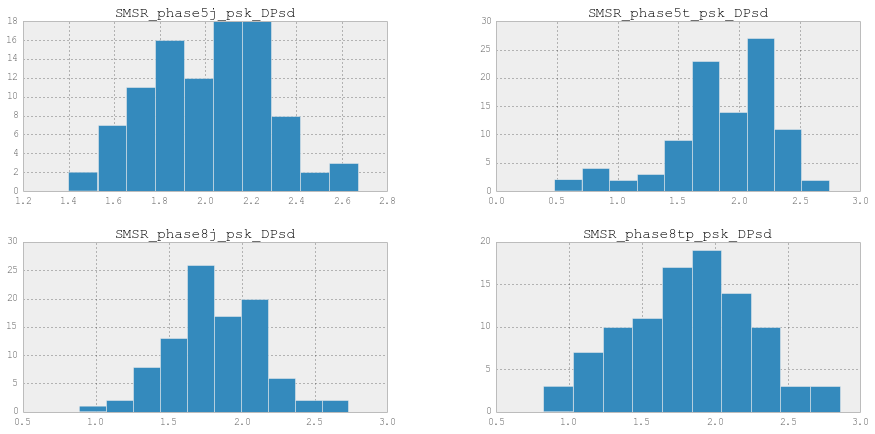

sqrt


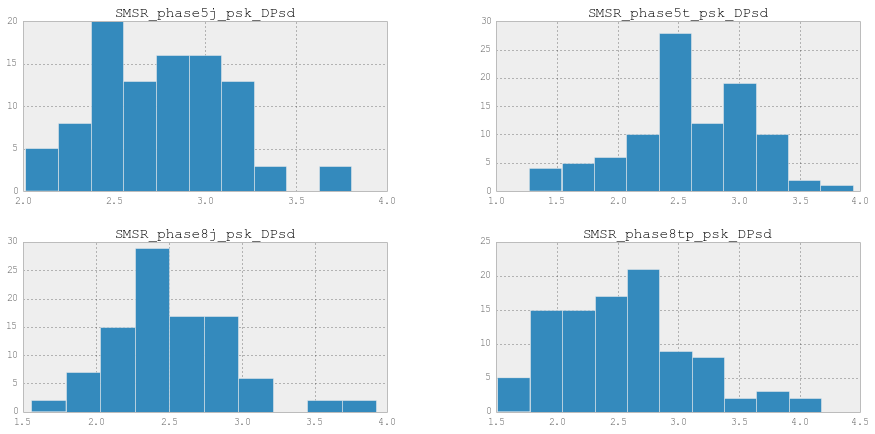

In [26]:
#quickcompare('DPsd$', df=dfo_flat_subset)
# demonstrates that the inverse transform works really well here (or did before I worked on earlier stages...)

quickcompare('nrm_DPsd', df=dfo_flat_subset)  #looks good
quickcompare('psk_DPsd', df=dfo_flat_subset)

In [30]:
scales = dfo.xs('scales', axis=1)
#scales

In [32]:
females = scales[scales.session_isfemale==True]
males = scales[scales.session_isfemale==False]
len(males)

allstats = scales.describe()[1:3]
malestats = males.describe()[1:3]
femalestats = females.describe()[1:3]

allstats.T

,mean,std
session_day,20140411.371134,74.619032
session_isfemale,0.608247,0.490678
sex_femalezero,0.391753,0.490678
participant_age,20.979381,5.055895
calc_wasivocab_totalrawscore,38.412371,5.448151
calc_wasivocab_tscore,52.360825,9.084311
calc_bfi_extraversion,3.518041,0.877227
calc_bfi_agreeableness,3.914089,0.626388
calc_bfi_conscientiousness,3.663230,0.640588
calc_bfi_neuroticism,2.854566,0.735095


In [ ]:
search= "ethnicity"
cols=concat_matches(scales, search)
cols.to_csv('ethnicity.csv')

In [125]:
concat_matches(scales, 'hours').describe().T

,count,mean,std,min,25%,50%,75%,max
qmusic_instrumenthours,97,7.927835,27.719107,0,0,0,4,250
qmusic_gamehoursall,97,5.569072,25.235418,0,0,0,3,240
qmusic_gamehoursdrumsticks,97,0.432990,1.396385,0,0,0,0,10
qmusic_singinghours_nonzero,97,0.206186,0.406667,0,0,0,0,1
qmusic_dancehours_nonzero,97,0.432990,0.498063,0,0,0,1,1
qmusic_instrumenthours_nonzero,97,0.422680,0.496552,0,0,0,1,1
qmusic_drumhours_nonzero,97,0.061856,0.242145,0,0,0,0,1
qmusic_gamehoursall_nonzero,97,0.484536,0.502357,0,0,0,1,1
qmusic_gamehoursdrumsticks_nonzero,97,0.195876,0.398935,0,0,0,0,1


In [123]:
len(scales.qmusic_dancelevel[scales.qmusic_dancelevel==0])

46

In [ ]:
search= "yn$"
cols=concat_matches(scales, search)
#cols.to_csv('qualifiers_yn.csv')
print(search+'\n------')

cols.apply(pd.value_counts).T

In [26]:
dfo.to_csv('csv_dfo_929.csv')

In [6]:
x = dfo.xs('isip5_avgprev3', axis=1).lagdev_avgprev3sq_local
y = dfo.xs('isip8_avgprev3', axis=1).lagdev_avgprev3sq_local

x.corr(y)


0.64749740485689034

,isip500local,isip800local
019,1.458044,2.409286
075,1.512254,2.097847
040,1.520219,2.595587
032,1.713234,1.580831
119,1.736570,2.134176
030,1.882929,2.266210
054,1.924084,2.853508
110,1.988980,2.310470
113,2.020436,1.798715
057,2.115470,2.445437


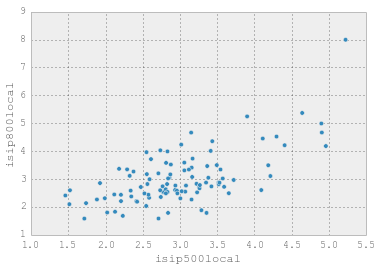

In [7]:
dfscatter = pd.concat([x, y], keys=['isip500local', 'isip800local'], axis=1)

#dfscatter_inverse = 1.0 / dfscatter
dfscatter.plot(x=0, y=1, kind='scatter')

#print((1 / x).corr(1 / y))

#(1 / dfscatter).plot(x=0, y=1, kind='scatter')

dfscatter.sort(columns='isip500local')

In [10]:
lookup = lambda text: [c for c in dfo_flat.columns 
                       if text in c]
lookup2 = lambda tup: set(lookup(tup[0])).intersection(set(lookup(tup[1])))
lookup2(('isip5', 'ints_count'))

{'isip5_avgprev2_x_ints_count',
 'isip5_avgprev3_x_ints_count',
 'isip5_avgprev4_x_ints_count',
 'isip5_avgprev_12_x_ints_count',
 'isip5_lag2_x_ints_count'}

In [18]:
compare = pd.concat([scales, sms_jitter, sms_ticks, dfo_isip8], axis=1)

#scales.append(sms_jitter) #['tick_index'] = sms_ticks_index
#scales.append(sms_ticks)
#scales['jit_index'] = sms_jitter_index
compare

,session_day,session_time,session_isfemale,exclusion_jitterlinearmissing,exclusion_rhythmadminerror,sex_femalezero,participant_age,calc_wasivocab_totalrawscore,calc_wasimatrix_totalscore,calc_agecolumn,...,ints_count,ints_mean,ints_variance,ints_stdev,lag2devsq_sum,lag2devsq_count,lag2devsq_mean,lag2devsq_local_sq_abs,lag2devsq_local,lag2devsq_drift
011,20140226,2:40pm,1,1,0,0,19,40,24,2,...,128,776.994000,883.209799,29.718846,208781.623552,126,1656.997012,828.498506,3.704488,0.951965
012,20140226,4:00pm,1,1,0,0,57,33,18,8,...,120,831.791733,986.297632,31.405376,176171.441216,118,1492.978315,746.489158,3.284711,1.861734
013,20140227,8:00am,0,1,1,1,21,42,20,3,...,114,834.087930,338.276056,18.392283,60632.582384,106,572.005494,286.002747,2.027558,0.866818
015,20140228,1:00pm,1,0,0,0,21,37,15,3,...,137,702.533956,2430.437702,49.299470,302872.981344,131,2312.007491,1156.003746,4.839632,5.081493
016,20140303,9:10am,0,0,0,1,19,48,22,2,...,112,811.894107,887.776090,29.795572,169532.034352,108,1569.741059,784.870529,3.450640,1.249453
017,20140303,10:30am,0,0,0,1,23,41,23,3,...,109,844.185541,1740.213950,41.715872,222698.851904,107,2081.297681,1040.648841,3.821327,3.133114
018,20140303,1:00pm,0,0,0,1,19,37,22,2,...,114,807.715930,1034.252108,32.159790,260203.336288,112,2323.244074,1161.622037,4.219624,NaN
019,20140303,2:20pm,0,0,0,1,19,40,23,2,...,116,794.750414,676.364586,26.007010,129798.102080,114,1138.579843,569.289921,3.002175,1.302005
020,20140303,3:37pm,0,0,0,1,18,41,20,2,...,111,819.063459,2114.370996,45.982290,308034.627472,107,2878.828294,1439.414147,4.632072,3.171907
021,20140304,9:40am,1,0,0,0,19,39,17,2,...,121,761.102909,1388.895981,37.267895,140437.019936,119,1180.143025,590.071512,3.191604,3.713490
